In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data Cleaning and Pre-processing

All required library imports for cleaning and pre-processing

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import re
import math
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Let's load the 3 JSON data files and combine them. We only need the three attributes: **'ingredients'** and **'instructions'**. The attributes 'picture_link' and 'title' are unnecessary for this task. We will remove any recipes that are missing any of the three attributes.

In [ ]:
# This function takes in a list of JSON files and merges the data
# Returns a list of dictionaries
def load_data(data_files,remove_attributes):
  merged_data = []
  for data_file in data_files:
    with open(MOUNT + data_file) as data:
      merged_data += list(json.load(data).values())

  # Remove the unneccessary attributes
  loaded_data = pd.DataFrame(merged_data).drop(columns=remove_attributes)
  print("Rows in Original Dataset: " + str(loaded_data.shape[0]))

  # Remove any rows where any of the columns that have NA or empty values
  loaded_data = loaded_data.replace('',np.nan).dropna()
  print("Rows in Filtered Dataset: " + str(loaded_data.shape[0]))

  # Replace any numbers in the ingredients

  return loaded_data.to_dict(orient='records')

MOUNT =  "/content/drive/MyDrive/recipes_raw/"
data_files = ['recipes_raw_nosource_ar.json','recipes_raw_nosource_epi.json','recipes_raw_nosource_fn.json']
remove_attributes = ['picture_link', 'title']
loaded_data = load_data(data_files, remove_attributes)

Rows in Original Dataset: 125164
Rows in Filtered Dataset: 124450


Let's remove any unneccessary noise from the data. On detailed investigation of the data it was found that some recipes have "ADVERTISEMENT" and "SOURCE*" show up in them. They aren't a part of the recipe. They exist in the data because the recipes were scraped from websites. These are likely html elements that weren't identifiable to be removed when the recipes were scraped. Let's also convert all the characters to lower case to reduce any form of bias.

We will also remove any numbers or punctuation. We will be removing measurements from the ingredients and instructions because we dont want the model to predict any ingredient measurements. All stopwords should also be removed as their abundance in sentences can affect outcomes.

In [ ]:
def remove_noise(loaded_data, noise_regex, special_tags):
    no_noise_data = []
    set_stop_words = set(stopwords.words('english'))

    for data in loaded_data:
      for key, value in data.items():
          if type(data[key]) is list:
              data[key] = ",".join(data[key])
          data[key] = re.sub(r'[^A-Za-z\s]','',data[key])
          for noise in noise_regex:
              data[key] = re.sub(noise, '', data[key])
          data[key] = data[key].split()
          str_data = ""
          for word in data[key]:
            if word.strip() not in set_stop_words and word.strip() not in measurements:
                str_data += word.lower().strip(" ") + " "
          data[key] = str_data

      no_noise_data.append((special_tags["begin"] + " " + data["ingredients"].strip(" ").strip("\n") + " " +  special_tags["end"],
                            special_tags["begin"] + " " + data["instructions"].strip("\n") + " " +  special_tags["end"]))
    return no_noise_data

noise_regex = [r'ADVERTISEMENT', r'\bSOURCE\b(.*)']
measurements = ['tablespoons' , 'cups', 'teaspoons', 'tablespoon', 'tbsp', 'ounce', 'oz', 'cup', 'teaspoon', 'tsp', 'pound', 'lb', 'gram', 'kg', 'milliliter', 'ml', 'liter', 'l']
special_tags = {"unknown": "<unk>","begin": "<bos>", "end" : "<eos>", "separate": "<sep>", "pad": "<pad>", "split": "<split>"}
noise_free_data = remove_noise(loaded_data, noise_regex, special_tags)


In [ ]:
# Clear memory
del[loaded_data]

Let's find the size of the largest recipe. Since we are using RNNs we dont want to make the sequence too long. To avoid running into the vanishing gradient problem. Lets find the overall distribution of the recipe lengths to figure out what the maximum length of our recipes should be and what recipes should be discarded.

Maximum Sequence Length for Recipe:  19219
Distribution of Recipe Lengths


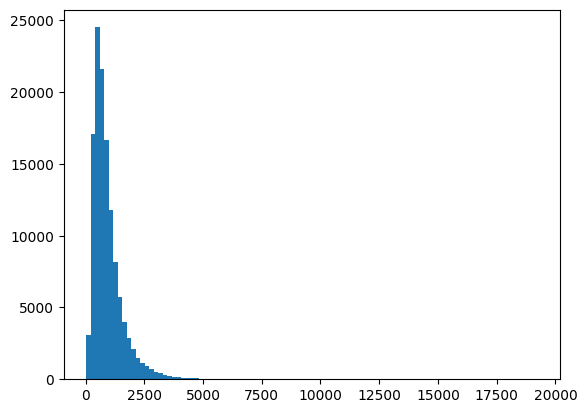



Length of 65th quartile of recipe lengths 957


In [ ]:
max_seq_length_recipe = 0
recipe_lengths = []

for x, t in noise_free_data:
    length = len(x) + len(t)
    if length > max_seq_length_recipe:
        max_seq_length_recipe = length
    recipe_lengths.append(length)

print("Maximum Sequence Length for Recipe: ", max_seq_length_recipe)

print("Distribution of Recipe Lengths")
plt.hist(recipe_lengths, bins=100)
plt.show()
print("\n")

recipes_65th = sorted(recipe_lengths)[math.ceil(len(recipe_lengths) * 0.65)]
print("Length of 65th quartile of recipe lengths", recipes_65th)


The 65th quartile has the length of 957. It should be okay to set MAX_SEQ_LENGTH_RECIPE to 957 words. Lets remove any recipes that dont have this.

In [ ]:
MAX_SEQ_LENGTH_RECIPE = 957

def remove_large_recipes(data):
    reasonable_size = []
    ingredients_len = 0
    instructions_len = 0
    for x, t in data:
          length_x = len(x)
          length_t = len(t)
          if (length_x + length_t) <= MAX_SEQ_LENGTH_RECIPE:
                reasonable_size.append((x,t))
    return reasonable_size


reasonable_data = remove_large_recipes(noise_free_data)
print("Length of the New Dataset: ", len(reasonable_data))

Length of the New Dataset:  80898


In [ ]:
del[noise_free_data]

# Tokenizing the Data set

All required libraries

In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator

Let's tokenize the data set and make a vocabulary. Only include words that are common i.e. shows up 30 times at least

In [ ]:
def make_vocabulary(data, special_tags):
    unique_words = []
    tokenized_data = []
    tokenizer = get_tokenizer("basic_english")
    for x, t in data:
        words_x = tokenizer(x)
        words_t = tokenizer(t)
        unique_words.append(words_x)
        unique_words.append(words_t)
        tokenized_data.append((words_x,words_t))
    vocabulary = build_vocab_from_iterator(unique_words, specials=special_tags, min_freq=30)
    print("Size of the vocabulary: ", len(vocabulary))
    return vocabulary, tokenizer, tokenized_data

def convert_numeric(data, vocabulary, tokenizer, unk):
    numeric_data = []
    max_len_x = 0
    max_len_t = 0
    vocab = vocabulary.get_stoi()
    for x, t in data:
        numeric_x = [vocab[token] if token in vocab.keys() else vocab[unk] for token in x]
        numeric_t = [vocab[token] if token in vocab.keys() else vocab[unk] for token in t]
        if len(numeric_x) > max_len_x:
            max_len_x = len(numeric_x)
        if len(numeric_t) > max_len_t:
            max_len_t= len(numeric_t)
        numeric_data.append((numeric_x,numeric_t))
    return numeric_data, max_len_x, max_len_t


vocabulary, tokenizer, tokenized_data = make_vocabulary(reasonable_data,list(special_tags.values()))
numeric_data, max_len_x, max_len_t =  convert_numeric(tokenized_data, vocabulary, tokenizer, special_tags['unknown'])

print("Maximum Sequence Length for Input: ", max_len_x)
print("Maximum Sequence Length for Target: ", max_len_t)

Size of the vocabulary:  4413
Maximum Sequence Length for Input:  106
Maximum Sequence Length for Target:  148


Let's pad the input and target sequences so they all have the same size

In [ ]:
MAX_SEQ_LENGTH_INGREDIENTS = 106
MAX_SEQ_LENGTH_INSTRUCTIONS = 148

full_dataset = []
pad_index = vocabulary.get_stoi()[special_tags['pad']]
for x, t in numeric_data:
    pads_x = [pad_index for i in range(MAX_SEQ_LENGTH_INGREDIENTS - len(x))]
    pads_t = [pad_index for j in range(MAX_SEQ_LENGTH_INSTRUCTIONS - len(t))]
    full_dataset.append((x + pads_x, t + pads_t))

print("Number of Recipes in Full Data Set: ", len(full_dataset))
print("Length of Input: ", len(full_dataset[54][0]))
print("Length of Target: ", len(full_dataset[54][1]))

Number of Recipes in Full Data Set:  80898
Length of Input:  106
Length of Target:  148


Now, let's split each recipe into input and target. We will be using the teacher forcing method for this. Then we will further divide the dataset into training, validation and training sets (60:20:20 divide).

In [ ]:
percent_60 = math.floor(len(full_dataset) * 0.6)
percent_20 = math.floor(len(full_dataset) * 0.2)

train_data = full_dataset[ : percent_60]
validation_data = full_dataset[percent_60 : percent_60 + percent_20]
test_data = full_dataset[percent_60 + percent_20 :]

print("Size of Training Set: ", len(train_data))
print("Size of Validation Set: ", len(validation_data))
print("Size of Test Set: ", len(test_data))

Size of Training Set:  48538
Size of Validation Set:  16179
Size of Test Set:  16181


**Example Tokenized Data**

In [ ]:
print("Input: ")
print(train_data[0][0])

print("Target: ")
print(train_data[0][1])

Input: 
[1, 473, 389, 38, 378, 363, 16, 370, 431, 30, 38, 182, 35, 108, 89, 651, 674, 1093, 115, 739, 112, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Target: 
[1, 28, 38, 16, 182, 35, 461, 480, 269, 292, 18, 59, 59, 20, 124, 151, 2140, 6, 94, 28, 739, 1093, 115, 461, 480, 20, 115, 415, 775, 186, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


# Storing the processed data for future use

Let's pickle the processed train, validation and test data set so we dont have to keep processing it.

Note: To make this code work please create a folder name "recipes_processed" in your Drive

In [ ]:
import pickle

STORED =  "/content/drive/MyDrive/recipes_processed/"

# Storing
with open(STORED + 'recipe_train_new.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open(STORED + 'recipe_validation_new.pkl', 'wb') as g:
    pickle.dump(validation_data, g)

with open(STORED + 'recipe_test_new.pkl', 'wb') as h:
    pickle.dump(test_data, h)

with open(STORED + 'recipe_vocab_new.pkl', 'wb') as i:
    pickle.dump(vocabulary, i)

with open(STORED + 'recipe_tokenizer_new.pkl', 'wb') as j:
    pickle.dump(tokenizer, j)

Here is the code to un-pickle these data sets

In [ ]:
with open(STORED + 'recipe_train_new.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open(STORED + 'recipe_validation_new.pkl', 'rb') as g:
    validation_data = pickle.load(g)

with open(STORED + 'recipe_test_new.pkl', 'rb') as h:
    test_data = pickle.load(h)

with open(STORED + 'recipe_vocab_new.pkl', 'rb') as i:
    vocabulary = pickle.load(i)

with open(STORED + 'recipe_tokenizer_new.pkl', 'rb') as j:
    tokenizer = pickle.load(j)

Let's visualize the un-pickled data

In [ ]:
print("Input: ")
print(train_data[0][0])

print("Target: ")
print(train_data[0][1])

print("Vocabulary Length")
print(len(vocabulary))

Input: 
[1, 473, 389, 38, 378, 363, 16, 370, 431, 30, 38, 182, 35, 108, 89, 651, 674, 1093, 115, 739, 112, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Target: 
[1, 28, 38, 16, 182, 35, 461, 480, 269, 292, 18, 59, 59, 20, 124, 151, 2140, 6, 94, 28, 739, 1093, 115, 461, 480, 20, 115, 415, 775, 186, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Vocabulary Length
4413
